<a href="https://colab.research.google.com/github/eridanirojas/563-rojas/blob/main/MDweek7HW_ERIDANIROJAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

fatal: destination path 'hoomd-organics' already exists and is not an empty directory.
✨🍰✨ Everything looks OK!


In [3]:
#!pip install --upgrade ipykernel #breaks things?
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda


Installing pip dependencies: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ Ran pip subprocess with arguments:
['/usr/local/bin/python', '-m', 'pip', 'install', '-U', '-r', '/c

In [157]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import hoomd
import numpy

In [158]:
del simulation

NameError: name 'simulation' is not defined

In [159]:
energy_values = {}
kT = 1.0
epsilon = 1.0
sigma = 1.0
final_density = 1.0
starting_density = 0.5
dts = [0.0005, 0.001, 0.005, 0.01]
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)

for dt in dts:
  print(dt)
  energy_values[f"{dt}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)

  #a is the spacing between particles
  a = 1/(starting_density**(1/3.0))
  #We want a number of particles N in our system.
  #Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
  num_replicas = 20
  N_particles = num_replicas**3
  grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
  if dt != 0.05:
    box_length = grid_particles[0].Lx
  else:
    box_length = grid_particles[0].Lx

  frame = gsd.hoomd.Frame()
  frame.particles.N = N_particles
  frame.particles.position = grid_particles[1]
  frame.configuration.box = [box_length,box_length,box_length,0,0,0]

  #Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
  #in a coarse-grained simulation we can give them a simple name like A
  frame.particles.typeid = [0]*N_particles
  frame.particles.types = ['A']

  #Finally, save our initial state:
  with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
      f.append(frame)

  simulation.create_state_from_gsd(filename='initial_state.gsd')

  integrator = hoomd.md.Integrator(dt = dt)
  nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
  integrator.methods.append(nve)

  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma

  integrator.forces.append(lj)
  simulation.operations.integrator = integrator

  simulation.run(200)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(thermodynamic_properties, quantities=['potential_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e3)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(1)
      energy_values[f"{dt}"].append(thermodynamic_properties.potential_energy)
  del simulation

0.0005
Simulation.timestep  Simulation.tps 
       1000             0.00000     
       2000             0.00000     
       3000             0.00000     
       4000             0.00000     
       5000             0.00000     
       6000             0.00000     
       7000             0.00000     
       8000             0.00000     
       9000             0.00000     
       10000            0.00000     
0.001
Simulation.timestep  Simulation.tps 
       1000             0.00000     
       2000             0.00000     
       3000             0.00000     
       4000             0.00000     
       5000             0.00000     
       6000             0.00000     
       7000             0.00000     
       8000             0.00000     
       9000             0.00000     
       10000            0.00000     
0.005
Simulation.timestep  Simulation.tps 
       1000             0.00000     
       2000             0.00000     
       3000             0.00000     
       4000        

In [154]:
del simulation

In [160]:
energy_values[f"{0.05}"] = []
simulation = hoomd.Simulation(device = device, seed = seed)

#a is the spacing between particles
a = 1/(0.3**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx * 5.0

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

simulation.create_state_from_gsd(filename='initial_state.gsd')

integrator = hoomd.md.Integrator(dt = 0.001)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

integrator.forces.append(lj)
simulation.operations.integrator = integrator

simulation.run(2000)

dt_values = [0.005, 0.01, 0.02]
for dt_equil in dt_values:
    integrator.dt = dt_equil
    simulation.run(2000)  # Stabilize before increasing dt further

integrator.dt = 0.05


simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=0.01)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties, quantities=['potential_energy'])
tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
tps_tracking.add(simulation, quantities=['timestep', 'tps'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e3)), logger=tps_tracking)
simulation.operations.writers.append(table)
for step in range(10000):
    print(step)
    simulation.run(1)
    energy_values[f"{0.05}"].append(thermodynamic_properties.potential_energy)
del simulation

**ERROR**: Particle with unique tag 1809 is no longer in the simulation box.

Cartesian coordinates: 
x: -117.055 y: -156.943 z: 69.9505
Fractional coordinates: 
f.x: -0.283607 f.y: -0.550631 f.z: 0.968271
Local box lo: (-74.6901, -74.6901, -74.6901)
          hi: (74.6901, 74.6901, 74.6901)


0
1
2
3
4
5
6
7
8
9
10
11
12
13


RuntimeError: Error computing cell list

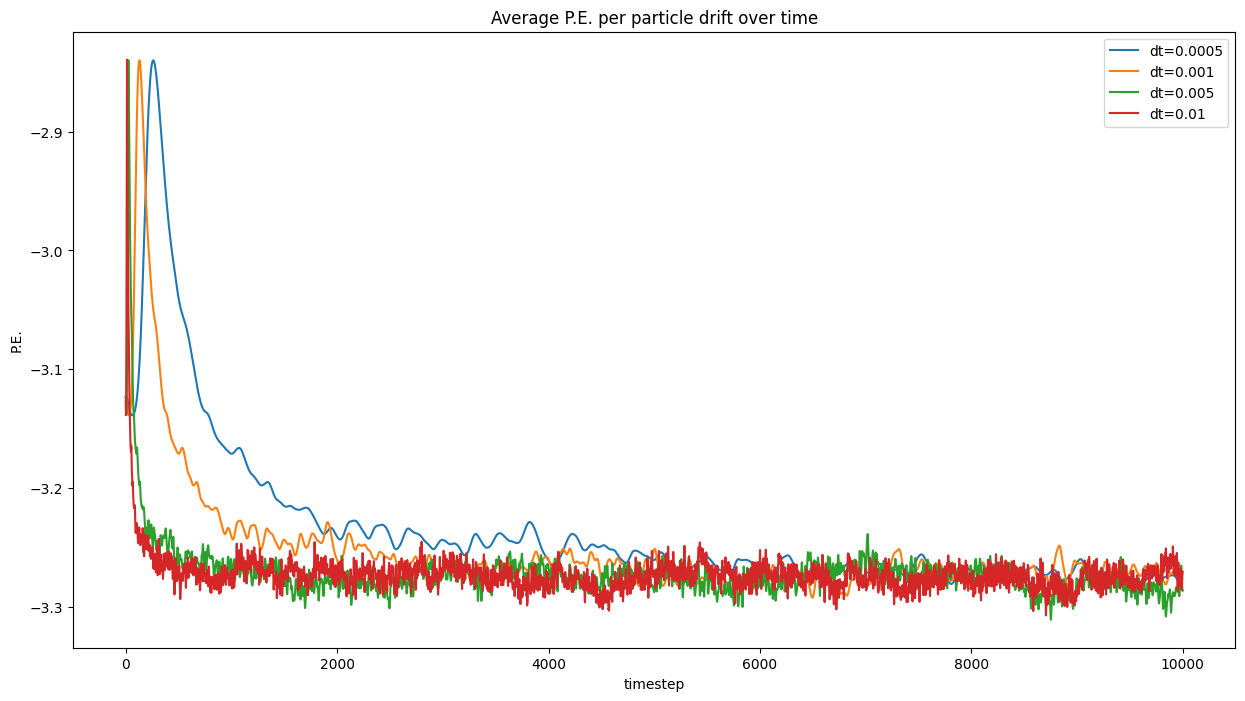

In [169]:
plt.figure(figsize = (15,8))
for dt, energies in energy_values.items():
    if dt != "0.05":
      plt.plot(numpy.array(energies[0:])/N_particles, label=f'dt={dt}')
plt.xlabel('timestep')
plt.ylabel('P.E.')
plt.title('Average P.E. per particle drift over time')
plt.legend()

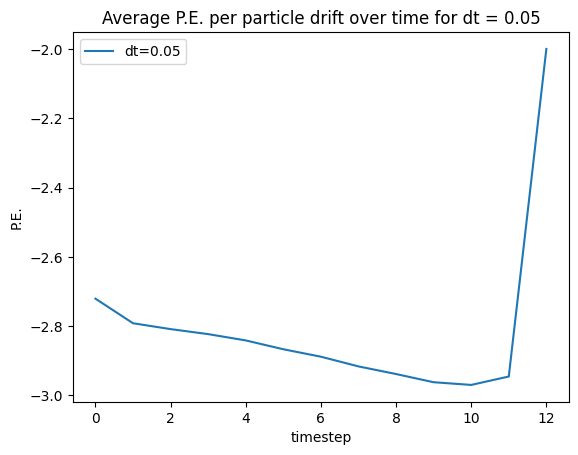

In [165]:
plt.plot(numpy.array(energy_values["0.05"])/N_particles, label=f'dt={0.05}')
plt.xlabel('timestep')
plt.ylabel('P.E.')
plt.title('Average P.E. per particle drift over time for dt = 0.05')
plt.legend()

### Falls apart at dt = 0.05, particles fly out of system. We are able to capture the energy drift still, which happens at around timesteps 10-12. I had to adjust box length, initial velocities, reduce initial density, as well as try and equilibrate the system gradually before getting this plot.